# XGB CPU

Total parameter combinations: 16

Combination 1/16 at 11:47:57
Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
Training Score: 0.8549
Test Score: 0.8583
Iteration Time: 00:00:22
New best score: 0.8583

Combination 2/16 at 11:48:20
Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
Training Score: 0.8766
Test Score: 0.8799
Iteration Time: 00:00:45
New best score: 0.8799

Combination 3/16 at 11:49:05
Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100}
Training Score: 0.8549
Test Score: 0.8583
Iteration Time: 00:00:22

Combination 4/16 at 11:49:28
Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200}
Training Score: 0.8766
Test Score: 0.8799
Iteration Time: 00:00:45

Combination 5/16 at 11:50:13
Parameters: {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100}
Training Score: 0.9035


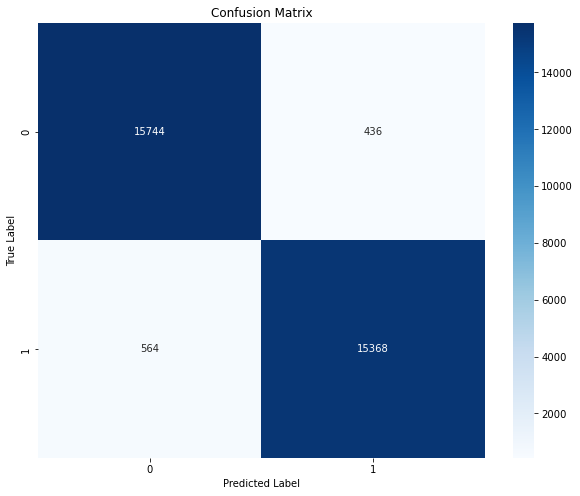


Accuracy: 0.9689


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import ParameterGrid
import numpy as np
import time
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Prepare data
X = df.drop('label', axis=1)
y = df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# Define reduced parameter grid
param_grid = {
    'max_depth': [3, 6],           # Control tree depth
    'learning_rate': [0.01, 0.1],  # Learning rate
    'n_estimators': [100, 200],    # Number of trees
    'min_child_weight': [1, 3]     # Minimum sum of instance weight
}

# Calculate total combinations
total_combinations = len([p for p in ParameterGrid(param_grid)])
print(f"Total parameter combinations: {total_combinations}")

# Initialize variables
best_score = 0
best_params = None
best_model = None

# Function to format time
def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

# Grid search with progress tracking
start_time = time.time()
for i, params in enumerate(ParameterGrid(param_grid), 1):
    iteration_start = time.time()
    current_time = time.strftime('%H:%M:%S')
    
    print(f"\nCombination {i}/{total_combinations} at {current_time}")
    print(f"Parameters: {params}")
    
    # Prepare XGBoost parameters
    xgb_params = {
        'max_depth': params['max_depth'],
        'learning_rate': params['learning_rate'],
        'min_child_weight': params['min_child_weight'],
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y)),
        'random_state': 42
    }
    
    # Train model
    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=params['n_estimators']
    )
    
    # Calculate scores
    train_pred = model.predict(dtrain)
    test_pred = model.predict(dtest)
    train_score = (train_pred == y_train).mean()
    test_score = (test_pred == y_test).mean()
    
    iteration_time = time.time() - iteration_start
    
    print(f"Training Score: {train_score:.4f}")
    print(f"Test Score: {test_score:.4f}")
    print(f"Iteration Time: {format_time(iteration_time)}")
    
    if test_score > best_score:
        best_score = test_score
        best_params = params
        best_model = model
        print(f"New best score: {best_score:.4f}")

# Print final results
total_time = time.time() - start_time
print("\n" + "="*50)
print("Grid Search Completed!")
print(f"Total Time: {format_time(total_time)}")
print(f"Best Parameters: {best_params}")
print(f"Best Test Score: {best_score:.4f}")

# Save the model and scaler
model_data = {
    'model': best_model,
    'scaler': scaler,
    'best_params': best_params,
    'best_score': best_score
}
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

# Fine-tuning phase
print("\nStarting fine-tuning phase...")

# Create simplified fine-tuning grid
fine_tune_grid = {
    'max_depth': [best_params['max_depth'] - 1, best_params['max_depth'], best_params['max_depth'] + 1],
    'learning_rate': [best_params['learning_rate'] * 0.5, best_params['learning_rate'], best_params['learning_rate'] * 1.5],
    'n_estimators': [best_params['n_estimators'] - 50, best_params['n_estimators'], best_params['n_estimators'] + 50],
    'min_child_weight': [best_params['min_child_weight']]
}

# Fine-tuning search
for i, params in enumerate(ParameterGrid(fine_tune_grid), 1):
    iteration_start = time.time()
    print(f"\nFine-tuning combination {i}/{len(list(ParameterGrid(fine_tune_grid)))}")
    
    xgb_params = {
        'max_depth': params['max_depth'],
        'learning_rate': params['learning_rate'],
        'min_child_weight': params['min_child_weight'],
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y)),
        'random_state': 42
    }
    
    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=params['n_estimators']
    )
    
    test_pred = model.predict(dtest)
    test_score = (test_pred == y_test).mean()
    
    if test_score > best_score:
        best_score = test_score
        best_params = params
        best_model = model
        print(f"New best score: {best_score:.4f}")

# Print final results
print("\n" + "="*50)
print("Fine-tuning Completed!")
print(f"Final Best Parameters: {best_params}")
print(f"Final Best Score: {best_score:.4f}")

# Save the final model and scaler
final_model_data = {
    'model': best_model,
    'scaler': scaler,
    'best_params': best_params,
    'best_score': best_score
}
with open('xgb_model_final.pkl', 'wb') as f:
    pickle.dump(final_model_data, f)

# Get predictions and evaluate
y_pred = best_model.predict(dtest)

# Print evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate and print accuracy
accuracy = (y_pred == y_test).mean()
print(f"\nAccuracy: {accuracy:.4f}")